# ML lab 03
# SVD: dimensionality reduction, visualization, compression and more

In [1]:
# Uncomment to upgrade packages
#!pip3 install pandas --user --upgrade --quiet
#!pip3 install scipy --user --upgrade --quiet
#!pip3 install numpy --user --upgrade --quiet
#!pip3 install statsmodels --user --upgrade --quiet
#!pip3 install seaborn --user --upgrade --quiet
#!pip3 install pillow --user --upgrade -- quiet
#!pip3 install matplotlib --user --upgrade --quiet

In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd

pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

---
## SECTION 1: Eigenvalues and eigenvectors

In linear algebra, an eigenvector or characteristic vector of a linear transformation is a non-zero vector that only changes by a scalar factor when that linear transformation is applied to it. 

If the vector space is finite-dimensional, then the linear transformation can be represented as a square 
matrix $ A $, and the vector $ q $ by a column vector, rendering the above mapping as a matrix multiplication on the 
left hand side and a scaling of the column vector on the right hand side in the equation

$$ Aq = \lambda q $$

The set of all eigenvectors of a linear transformation, each paired with its corresponding eigenvalue, is called the 
eigensystem of that transformation.

When we place all of these equations (corresponding to the $n$ eigenvalues with their eigenvectors), this leads to the eigendecomposition of $A$:

$$ AQ = Q \Lambda $$

Spelling this out:

$$
A \begin{bmatrix}\mathbf{q}_1\ \mathbf{q}_2\ \cdots\ \mathbf{q}_n\end{bmatrix} = 
\begin{bmatrix}\mathbf{q}_1\ \mathbf{q}_2\ \cdots\ \mathbf{q}_n\end{bmatrix} 
\begin{bmatrix}
    \lambda_1 & 0 & \dots & 0 \\
    0 & \lambda_2 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & \lambda_n
  \end{bmatrix} = 
  \begin{bmatrix}\lambda_1\mathbf{q}_1\ \lambda_2\mathbf{q}_2\ \cdots\ \lambda_n\mathbf{q}_n\end{bmatrix} 
$$


### Eigendecomposition of symmetric matrix $A\in {\mathbb R}^{n \times n}$

If a matrix $A\in {\mathbb R}^{n \times n}$ is symmetric and full-rank, then $A = Q\Lambda Q^T$.
More visually, if $\mathbf{q}_1,..,\mathbf{q}_n$ are the columns of $Q$ (eigenvectors of $A$), then:

$$
A = \begin{bmatrix}\mathbf{q}_1\ \mathbf{q}_2\ \cdots\ \mathbf{q}_n\end{bmatrix} \begin{bmatrix}
    \lambda_1 & 0 & \dots & 0 \\
    0 & \lambda_2 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & \lambda_n
  \end{bmatrix} \begin{bmatrix} \mathbf{q}_1^T\\ \mathbf{q}_2^T\\ \cdots\\ \mathbf{q}_n^T \end{bmatrix}
$$

1. $Q$ is orthonormal matrix (all vectors are orthogonal and have unit length); its columns are the eigenvectors of $A$ and form a basis; and so $Q^T Q = I$ and $Q^{-1} = Q^T$
2. $\Lambda$ is diagonal and contains all eigenvalues of $A$


This factorization allows us to compute certain operations very efficiently, e.g.:

- powers of A: $A^k = (Q\Lambda Q^T)^k = (Q\Lambda Q^T) (Q\Lambda Q^T) \ldots (Q\Lambda Q^T) = Q \Lambda^k Q^T$
- inverse of A: $A^{-1} = (Q\Lambda Q^T)^{-1} = Q \Lambda^{-1} Q^T$




In [4]:
from numpy.linalg import eig, inv

# generate random symmetric matrix
n=5
a = np.random.randint(50, size=(n, n))
A = np.tril(a) + np.tril(a, -1).T
print(A)

[[33 37 21 13 35]
 [37 26 34  5 49]
 [21 34 12  7 24]
 [13  5  7 36 16]
 [35 49 24 16 21]]


In [5]:
eigvalues, eigvectors = eig(A)

print(f'Eigenvalues: {eigvalues}')
print(f'Eigenvectors:')
print(eigvectors)

Eigenvalues: [130.409  33.047   1.711  -8.896 -28.271]
Eigenvectors:
[[-0.502 -0.025 -0.801  0.325  0.022]
 [-0.55  -0.241  0.234 -0.241 -0.726]
 [-0.364 -0.125  0.528  0.714  0.251]
 [-0.213  0.962  0.11   0.025 -0.131]
 [-0.518 -0.027  0.111 -0.571  0.627]]


In [6]:
print(A @ eigvectors)
print()
print(eigvectors @ np.diag(eigvalues))

[[-65.435  -0.827  -1.37   -2.887  -0.633]
 [-71.677  -7.973   0.4     2.145  20.521]
 [-47.513  -4.147   0.904  -6.351  -7.084]
 [-27.772  31.778   0.188  -0.224   3.713]
 [-67.517  -0.887   0.19    5.082 -17.713]]

[[-65.435  -0.827  -1.37   -2.887  -0.633]
 [-71.677  -7.973   0.4     2.145  20.521]
 [-47.513  -4.147   0.904  -6.351  -7.084]
 [-27.772  31.778   0.188  -0.224   3.713]
 [-67.517  -0.887   0.19    5.082 -17.713]]


check the condition that  $Aq = \lambda q$ for all $q$ and $\lambda$:

In [7]:
# make sure they are the same..
print(f'AQ =? QL: {np.allclose(A @ eigvectors, eigvectors @ np.diag(eigvalues))}')

AQ =? QL: True


---
## SECTION 2: SVD, what it is, how to compute it

### Singular Value Decomposition of a rectangular matrix $A\in\mathbb{R}^{m \times n}$

Any matrix $A\in\mathbb{R}^{m \times n}$ with $m>n$ can be expressed as 
$$A = U \Sigma V^T$$

where:

- $U \in\mathbb{R}^{m \times n}$ has orthonormal columns (so $U^T U = I$)
- $\Sigma\in\mathbb{R}^{n \times n}$ is diagonal and contains the singular values in its diagonal
- $V\in\mathbb{R}^{n \times n}$ has orthonormal rows and columns (so $V^T V = I$, $V V^T = I$ and $V^{-1} = V^T$)

With matrices spelled out, this is:

$$
\begin{aligned}A &= \begin{bmatrix}\mathbf{u}_1\ \mathbf{u}_2\ \cdots\ \mathbf{u}_n\end{bmatrix} \begin{bmatrix}
    \sigma_1 & 0 & \dots & 0 \\
    0 & \sigma_2 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & \sigma_n
  \end{bmatrix} \begin{bmatrix} \mathbf{v}_1^T\\ \mathbf{v}_2^T\\ \cdots\\ \mathbf{v}_n^T \end{bmatrix} \\ \\
  &= \sigma_1\mathbf{u}_1\mathbf{v}_1^T + \sigma_2\mathbf{u}_2\mathbf{v}_2^T + ... + \sigma_n\mathbf{u}_n\mathbf{v}_n^T
  \end{aligned}
 $$


The case where $m < n$ is the same, with different sizes for the matrices:

- $U \in\mathbb{R}^{m \times m}$ has orthonormal columns (so $U^T U = I$)
- $\Sigma\in\mathbb{R}^{m \times m}$ is diagonal and contains the singular values in its diagonal
- $V\in\mathbb{R}^{m \times n}$ has orthonormal rows and columns (so $V^T V = I$, $V V^T = I$ and $V^{-1} = V^T$)

For a visual illustration:

|![](svd1.png) | ![](svd2.png) |
|:------------:|:-------------:|




### Computing the SVD of a rectangular matrix $A\in\mathbb{R}^{m \times n}$

The nonzero singular values of $A\in\mathbb{R}^{m \times n}$ are the (positive) square roots of the nonzero eigenvalues of $A^T A$ and $A A^T$

- Let $A = U\Sigma V^T$ be the SVD decomposition of $A$
- Then $A^T A = (U\Sigma V^T)^T U\Sigma V^T = V^{TT}\Sigma^T U^T U\Sigma V^T = V \Sigma^2 V^T$ so $V$ contains the eigenvectors of $A^T A$ and $\sigma_i^2$ are its eigenvalues 
- Also  $A A^T = U\Sigma V^T (U\Sigma V^T)^T = U\Sigma V^T V^{TT}\Sigma^T U^T  = U \Sigma^2 U^T$ so $U$ contains the eigenvectors of $A A^T$ and $\sigma_i^2$ are its eigenvalues 

So the algorithm for computing SVD decomposition of $A$ is:

1. If $m<n$:
    - Compute eigendecomposition $U \Lambda U^T$ of $A A^T$
    - Set $\Sigma = \Lambda^{\frac{1}{2}}$
    - Set $V^T = \Sigma^{-1} U^T A$
2. If $n<m$:
    - Compute eigendecomposition $V \Lambda V^T$ of $A^T A$
    - Set $\Sigma = \Lambda^{\frac{1}{2}}$
    - Set $U = A V \Sigma^{-1}$


---
## SECTION 3: Computation of least squares solution

Let us look closely at the solution for coefficients $\mathbf{\theta}$ via minimization of the least squared error:

$$\mathbf{\theta}_{lse} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

- $\mathbf{X} \in {\mathbb R}^{n \times (d+1)}$
- $\mathbf{X}^T\mathbf{X} \in {\mathbb R}^{(d+1) \times (d+1)}$
- If $\mathbf{X}$ has independent columns, then $\mathbf{X}^T\mathbf{X}$ is invertible
- Inverting this matrix can have numerical problems and so the SVD is used instead

The term $(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T$ is called the *pseudoinverse* of $X$. In fact:

$$pinv(X) X = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T X = I$$

### Computing least squares solution via the SVD

Let $\mathbf{X} = U \Sigma V^T$ be the SVD  decomposition of data matrix $\mathbf{X}$

Then:
$$
\begin{aligned}
\mathbf{\theta}_{lse} &=  (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
  &= ((U \Sigma V^T)^T U \Sigma V^T)^{-1} (U \Sigma V^T)^T \mathbf{y} \\
  &= (V\Sigma U^T U\Sigma V^T)^{-1} V \Sigma U^T\mathbf{y} \\
  &= (V \Sigma^2 V^T)^{-1} V \Sigma U^T\mathbf{y} \\
  &= (V^T)^{-1} \Sigma^{-2} V^{-1} V \Sigma U^T \mathbf{y} \\
  &= V \Sigma^{-1} U^T \mathbf{y} \\
\end{aligned}
$$




In [8]:
murders = pd.read_csv('murders.txt', sep=' ')
murders['offset'] = [1.0] * len(murders)
murders.head()

,inhabitants,income,unemployment,murders,offset
0,587,16.5,6.2,11.2,1.0
1,643,20.5,6.4,13.4,1.0
2,635,26.3,9.3,40.7,1.0
3,692,16.5,5.3,5.3,1.0
4,1248,19.2,7.3,24.8,1.0


In [9]:
X = murders[['offset', 'inhabitants', 'income', 'unemployment']].to_numpy()
print(X.shape)
y = murders[['murders']].to_numpy()
print(y.shape)

(20, 4)
(20, 1)


In [10]:
from numpy.linalg import svd, pinv, inv

In [11]:
# compute theta the direct way
theta_inv = inv(X.T @ X) @ X.T @ y
theta_inv

array([[-3.676e+01],
       [ 7.629e-04],
       [ 1.192e+00],
       [ 4.720e+00]])

In [12]:
# compute theta the pseudoinverse way
from numpy.linalg import pinv

theta_pinv = pinv(X) @ y
theta_pinv

array([[-3.676e+01],
       [ 7.629e-04],
       [ 1.192e+00],
       [ 4.720e+00]])

In [13]:
# compute theta the SVD way

U,d,Vt = svd(X, full_matrices=False)
theta_svd = Vt.T @ np.diag(1/d) @ U.T @ y
theta_svd

array([[-3.676e+01],
       [ 7.629e-04],
       [ 1.192e+00],
       [ 4.720e+00]])

In [14]:
# check they are the same..
np.allclose(theta_inv, theta_svd)

True

---
## SECTION 4: Compressing images with SVD

In this section we will see a fun application of (truncated) SVD that allows us to compress images. Remember that
we defined the SVD of a rectangular matrix $A\in\mathbb{R}^{m \times n}$ as
$$A = U \Sigma V^T$$

It is instructive to think of the multiplications as the sum of rank-1 matrices with the same shape as $A$:

$$
A = \sigma_1\mathbf{u}_1\mathbf{v}_1^T + \sigma_2\mathbf{u}_2\mathbf{v}_2^T + ... + \sigma_n\mathbf{u}_n\mathbf{v}_n^T
$$

We can use only the first $k$ terms in this sum to represent $A$, having to store only $k$ singular values $\sigma_1 \dots \sigma_k$ and $2k$ vectors $\mathbf{u}_1,\dots,\mathbf{u}_k$ and $\mathbf{v}_1,\dots,\mathbf{v}_k$. So we go from storing $n\times m$ values to storing $k (1 + n + m)$
where $k \ll min(n,m)$


## First, let us load a random image..

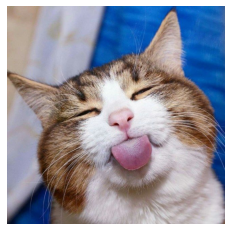

(650, 650, 3)

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('cat.jpg')
A = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.show()
A.shape

(650, 650)
original image uses 422500 values


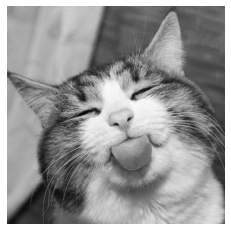

In [16]:
#convert to 2D image from 3 RGB channels

X = np.mean(A, axis=2)
plt.imshow(X, cmap=plt.cm.gray)
plt.axis('off')
print(X.shape)
print(f'original image uses {np.prod(X.shape)} values')

## Perform SVD decomposition on $X$

In [17]:
U,d,Vt = svd(X)
D = np.diag(d)

np.allclose(X, U @ D @ Vt)

True

Original image needs 650 x 650 = 422500 values


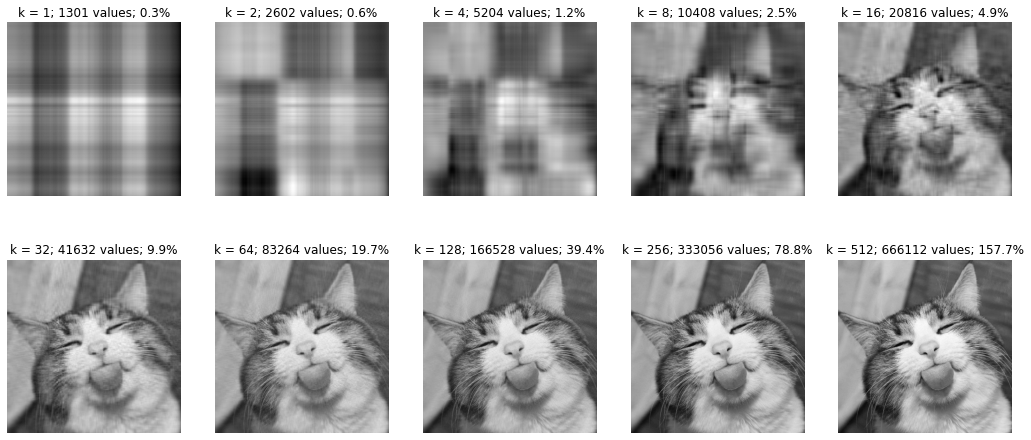

In [18]:
# k looping through sequence of powers of 2
m,n = X.shape
nm = np.prod(X.shape)
print(f'Original image needs {n} x {m} = {nm} values')
j = 0
plt.figure(figsize=(18, 8))
for k in [1 << i for i in range(10)]:
    plt.subplot(2,5,j+1)
    j += 1
    ## construct approximation of X with first $k$ dimensions
    X_approx = U[:,:k] @ D[:k,:k] @ Vt[:k,:]
    plt.imshow(X_approx, cmap=plt.cm.gray)
    plt.axis('off')
    storage = k*(m+n+1)
    plt.title(f'k = {k}; {storage} values; {storage/nm*100:.1f}%')

### Plotting singular values

Text(0.5, 1.0, 'Cumulative sum of singular values')

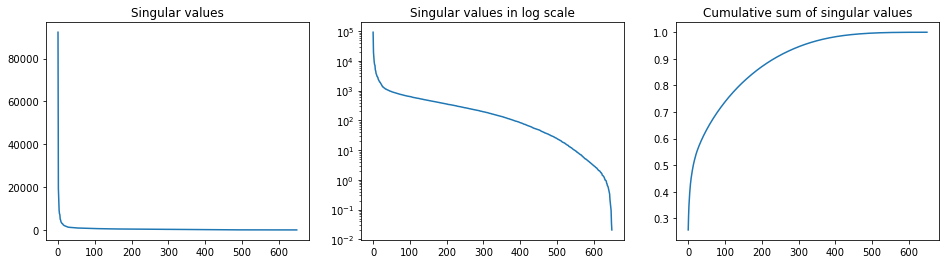

In [19]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(d)
plt.title('Singular values')

plt.subplot(132)
plt.semilogy(d)
plt.title('Singular values in log scale')

plt.subplot(133)
plt.plot(np.cumsum(d) / np.sum(d))
plt.title('Cumulative sum of singular values')

---
## SECTION 4: Eigenfaces

In this last section we are going to apply SVD to a **collection** of images, each image will be a "row" in a matrix and we will perform SVD on this
matrix in order to compute the eigenvalues and eigenvectors of a collection of faces downloaded from UMass's [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/index.html).

### First load all images using scikit-learn

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=17)   # only load images of people for which we have >= 17 images

n = faces.data.shape[0]

In [21]:
print(faces.target_names[:20])

print(f'faces.data.shape: {faces.data.shape}')
print(f'faces.image.shape: {faces.images.shape}')


['Abdullah Gul' 'Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo'
 'Andre Agassi' 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Bill Gates' 'Carlos Menem'
 'Carlos Moya' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'Fidel Castro' 'George Robertson' 'George W Bush' 'Gerhard Schroeder']
faces.data.shape: (3382, 2914)
faces.image.shape: (3382, 62, 47)


In [22]:
# size of first image, we assume all images are the same size..
h, w = faces.images[0].shape

print(f'Found {n} images of size {h} x {w} = {h*w} belonging to {len(faces.target_names)} different persons.')

X = faces.data    # X is a matrix of shape 4324 x 2914 containing flattened images in each row

assert X.shape[1] == h * w

print(f'data matrix X has size {X.shape} -- one flattened image in each row')

Found 3382 images of size 62 x 47 = 2914 belonging to 82 different persons.
data matrix X has size (3382, 2914) -- one flattened image in each row


### Show random faces from our dataset

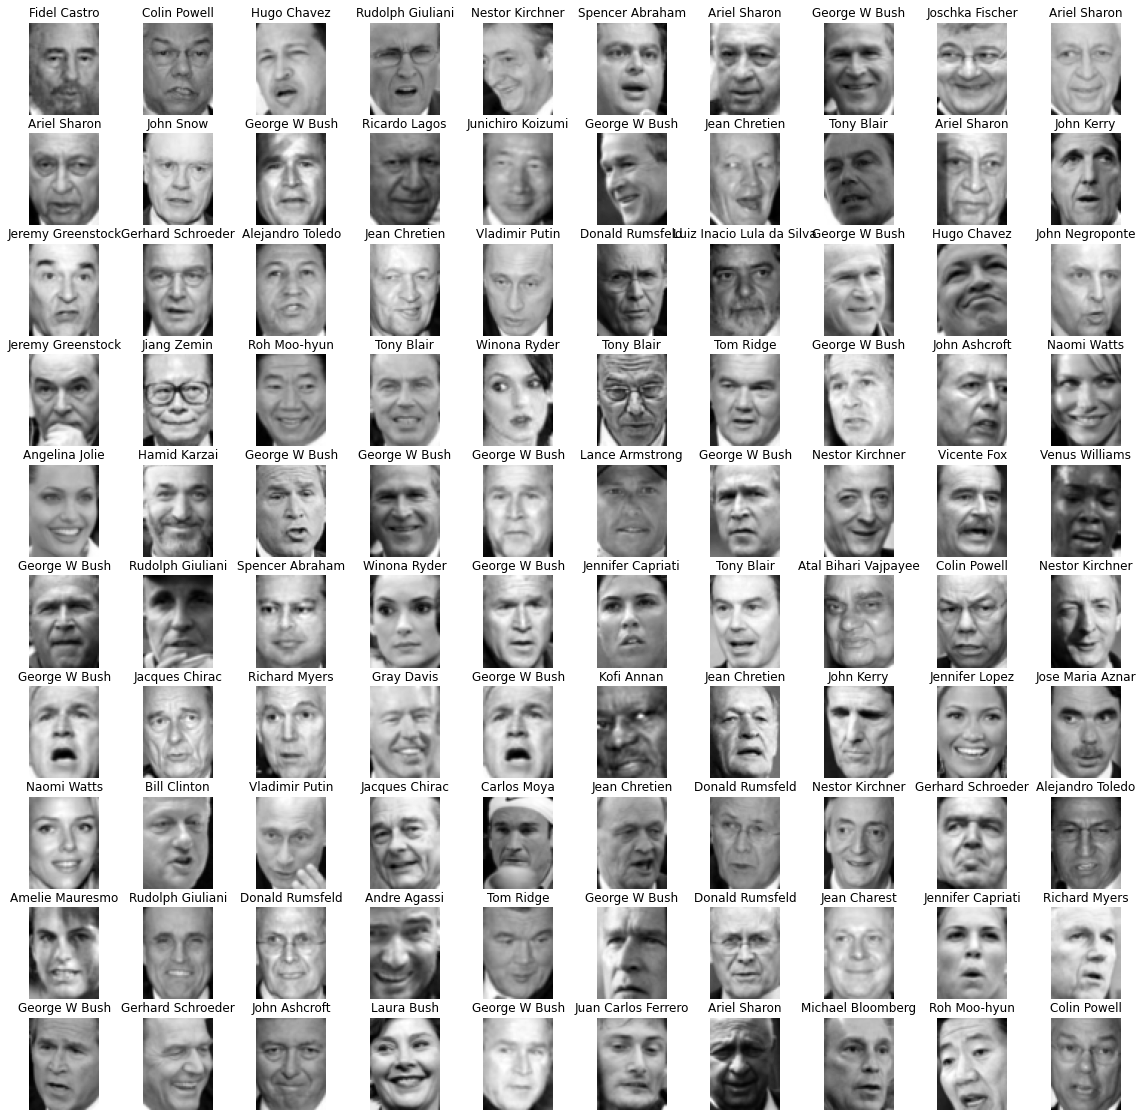

In [23]:
plt.figure(figsize=(20, 20))

# select 100 random images
rand_images = np.random.randint(n, size=100)

for i in range(10*10):
    plt.subplot(10,10,i+1)
    idx = rand_images[i]  # pick random person (random row from X)
    plt.imshow(X[idx,:].reshape(h,w), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(faces.target_names[faces.target[idx]])


### Compute mean face; substract mean face from all our faces (will work on centered data... so like PCA)

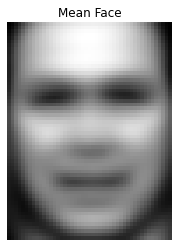

In [24]:
mean_face = X.mean(axis=0)
plt.imshow(np.reshape(mean_face, (h,w)), cmap=plt.cm.gray)
plt.title("Mean Face")
plt.axis('off')
plt.show()

In [25]:
# center data
cX = X - mean_face

### Redraw centered images

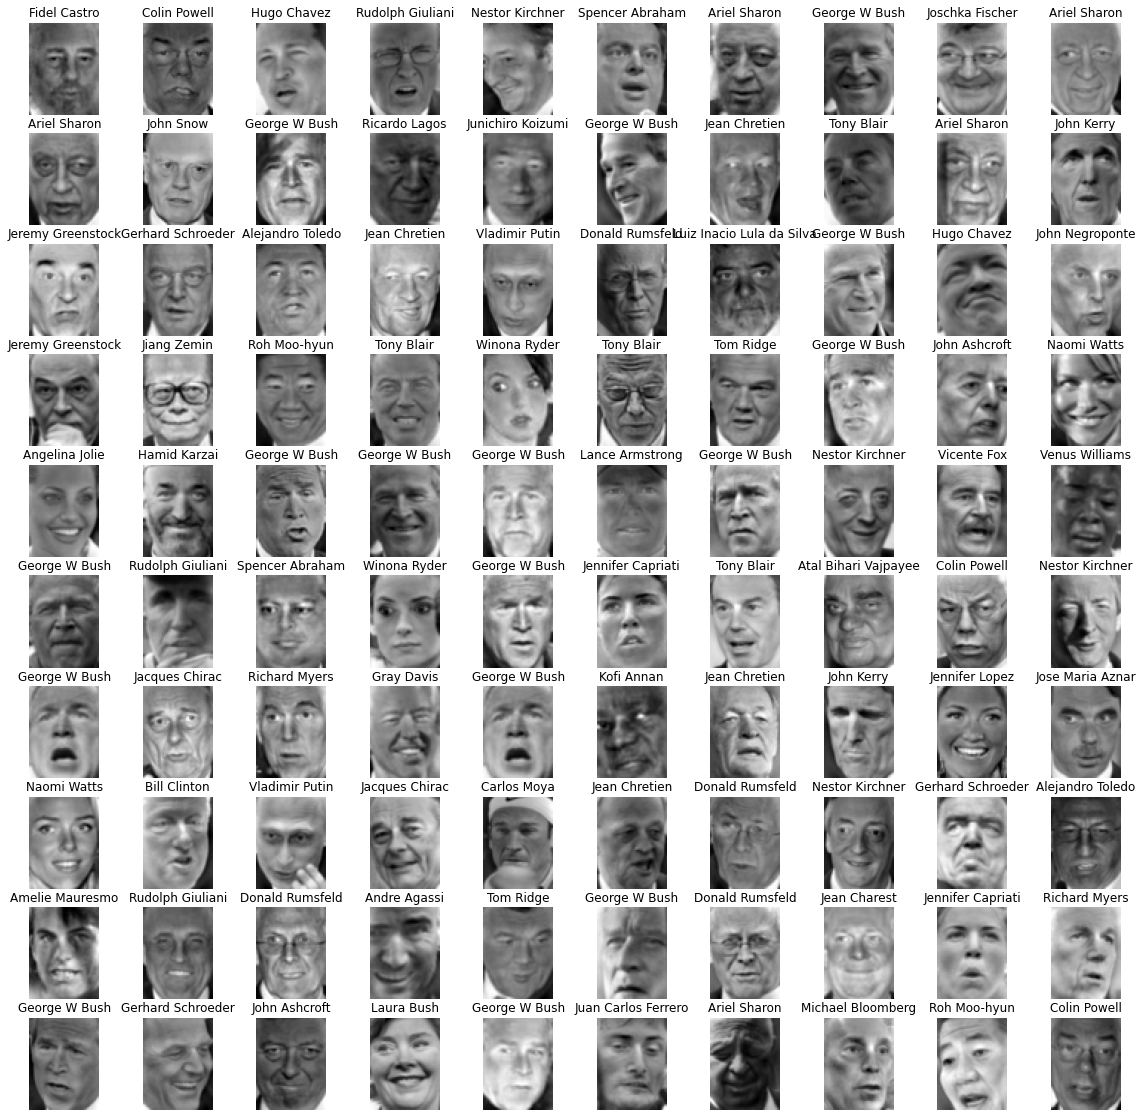

In [26]:
plt.figure(figsize=(20, 20))
for i in range(10*10):
    plt.subplot(10,10,i+1)
    idx = rand_images[i]  # pick random person (random row from X)
    plt.imshow(cX[idx,:].reshape(h,w), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(faces.target_names[faces.target[idx]])


In [27]:
%%time
U, d, Vt = svd(cX, full_matrices=False)

CPU times: user 32.2 s, sys: 1.6 s, total: 33.8 s
Wall time: 9.42 s


In [28]:
U.shape, d.shape, Vt.shape

((3382, 2914), (2914,), (2914, 2914))

In [29]:
# check it worked..

svd_X = U @ np.diag(d) @ Vt

print(np.allclose(cX, svd_X, atol=1e-08))
print(np.allclose(cX, svd_X, atol=1e-03))

from scipy import stats

stats.describe(cX - svd_X, axis=None)

False
True


DescribeResult(nobs=9855148, minmax=(-0.000289917, 0.0002746582), mean=2.2900256e-08, variance=3.1679537e-10, skewness=0.007707312237471342, kurtosis=7.53006191595844)

### Show first eigenvectors..

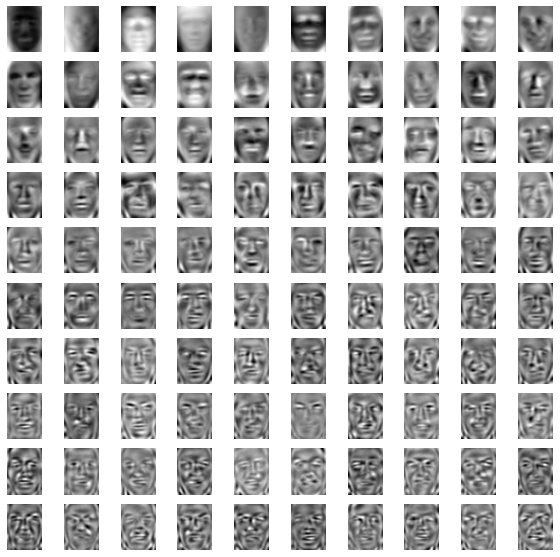

In [30]:
plt.figure(figsize=(10, 10))
for i in range(10*10):
    plt.subplot(10,10,i+1)
    plt.imshow(Vt[i,:].reshape(h,w), cmap=plt.cm.gray)
    plt.axis('off')    

### Plot singular values

Text(0.5, 1.0, 'Cumulative sum of singular values')

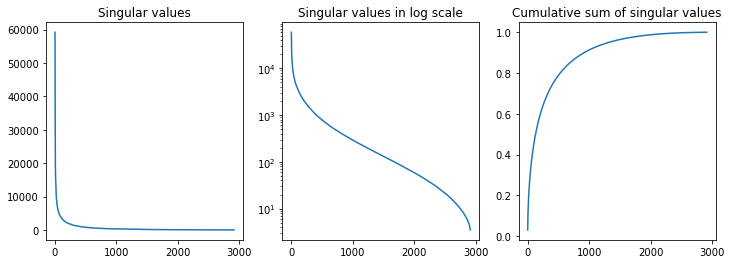

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(d)
plt.title('Singular values')

plt.subplot(132)
plt.semilogy(d)
plt.title('Singular values in log scale')

plt.subplot(133)
plt.plot(np.cumsum(d) / np.sum(d))
plt.title('Cumulative sum of singular values')

### Columns of $V$ as new basis for images

Remember that the SVD decomposition of our image matrix is

$$
X = \sigma_1\mathbf{u}_1\mathbf{v}_1^T + \sigma_2\mathbf{u}_2\mathbf{v}_2^T + ... + \sigma_n\mathbf{u}_n\mathbf{v}_n^T
$$

It is useful to see what happens with a single row of $X$ (that is, one image). If you apply the decomposition you can see that it is now expressed as a **linear combination** of rows of $V^T$, i.e. columns of $V$; the coefficients of the linear combination are given by the corresponding component of the columns of $U$ multiplied by the corresponding singular value (see below). So, columns of $V$ represent new orthonormal basis for rows of $X$. Each **eigenface** is thus an element of the new orthonormal basis for images (rows) of $X$.

$$
\begin{aligned}
X[i,:] = \mathbf{x}_i &= \sigma_1 u[i]_1 \mathbf{v}_1^T + \sigma_2 u[i]_2 \mathbf{v}_2^T + ... + \sigma_n u[i]_n \mathbf{v}_n^T \\
    &= \alpha_1 \mathbf{v}_1^T + \alpha_2 \mathbf{v}_2^T + ... + \alpha_n \mathbf{v}_n^T 
\end{aligned}
$$

where each $\alpha_j = \sigma_j u[i]_j$; the coefficient vector $\mathbf{\alpha}$ constitutes the new "fingerprint" of the image $\mathbf{x}_i$. Given the space of eigenvectors in $V$, it is enough to reconstruct an image to give its *signature* coefficients $\alpha$.

Again, to save space, we can only keep the first terms in the sum (say the first $k$ terms corresponding the most important eigenvectors) and so with this truncated sum we will only  *approximate*  rows of $X$. So, in order to store the whole collection of images, it is enough to store the most important eigenfaces, and then for each image we just need to store the coefficients used to restore it with satisfactory precision.

In essence, by truncating the sum we are performing **dimensionality reduction** from this high dimensional space (each image has $62 \times 47 = 2914$ features -- namely its pixels) down to $k$ coefficients.

### Showing some coefficients for a sample image

In [32]:
i = np.random.randint(n) # select random image
alpha = U[i,:] @ np.diag(d)
print(alpha.shape)
print(alpha)

(2914,)
[-2.015e+03 -1.276e+03 -1.213e+02 ... -3.317e-02  1.899e-02  3.151e-02]


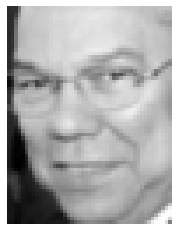

In [33]:
plt.imshow((mean_face + cX[i,:]).reshape(h,w), cmap=plt.cm.gray)
plt.axis('off');

### we are going to reconstruct this image using a few eigenfaces..

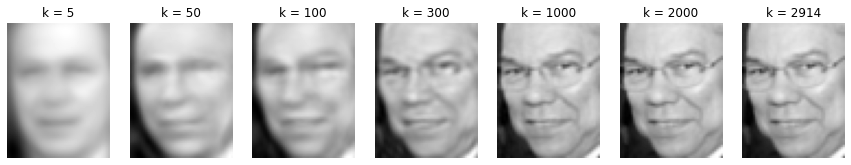

In [34]:
plt.figure(figsize=(15, 40))
j = 1
k_range = [5, 50, 100, 300, 1000, 2000, Vt.shape[0]] 
for k in k_range:
    plt.subplot(1,len(k_range),j)
    j += 1
    reconstructed = mean_face + alpha[:k] @ Vt[:k,:]
    plt.imshow(reconstructed.reshape(h,w), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('k = ' + str(k))

### "Folding in" new images

We can project an image $\mathbf{x}'$ _outside_ our matrix $X$ onto the same space and compute its coefficients using the transformation $$\mathbf{\alpha}' = \mathbf{x}'  V$$ 

This way we can represent
any vector as the linear combination of eigenfaces; using the same trick as above we can reconstruct it using the truncated space

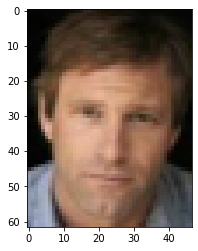

In [35]:
# pick an image outside X

image = Image.open('Aaron_Eckhart_0001.jpg')
image = image.crop((60, 25, 185, 200))
image = image.resize((w, h))
plt.imshow(image)

A = np.array(image).mean(axis=2)

new_x = A.reshape(1 , -1) - mean_face
new_alpha = new_x @ Vt.T
new_alpha = new_alpha.reshape(-1)


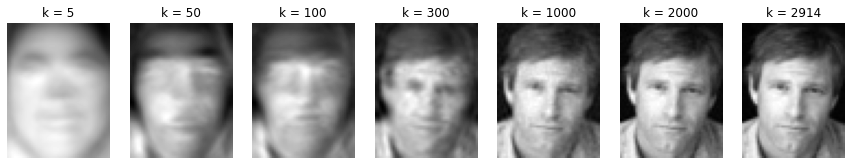

In [36]:
plt.figure(figsize=(15, 40))
j = 1
k_range = [5, 50, 100, 300, 1000, 2000, Vt.shape[0]] 
for k in k_range:
    plt.subplot(1,len(k_range),j)
    j += 1
    reconstructed = mean_face + new_alpha[:k] @ Vt[:k,:]
    plt.imshow(reconstructed.reshape(h,w), cmap=plt.cm.gray)
    plt.title('k = ' + str(k))
    plt.axis('off')

### Using our svd as visualization tool

Finally, project all observations down to 2D for visualization using two coefficients (not necessarily the first two)

We are going to pick two different people (with several images each) from our database, and project them onto 2D; let us see if faces from same people fall in similar regions.

We have selected 'Naomi Watts' and 'Bill Gates' since they seem different enough and have many images each.

In [37]:
# find images from a name
watts_pos = np.where(faces.target_names =='Naomi Watts')[0][0]
gates_pos = np.where(faces.target_names =='Bill Gates')[0][0]

#print(watts_pos, gates_pos)

watts_idx = np.where(faces.target == watts_pos)[0]
gates_idx = np.where(faces.target == gates_pos)[0]

#print(f'Naomi in rows: {watts_idx}')
#print(f'Gates in rows: {gates_idx}')

print(f'Found {len(watts_idx)} images of Naomi Watts; {len(gates_idx)} images from Bill Gates')

Found 22 images of Naomi Watts; 17 images from Bill Gates


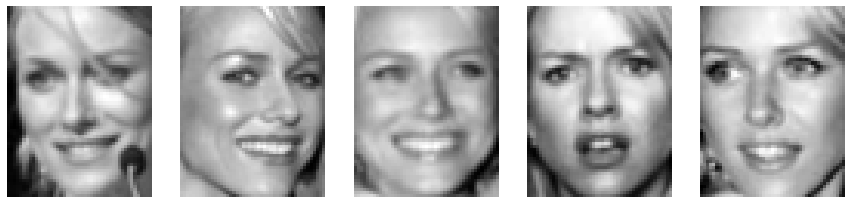

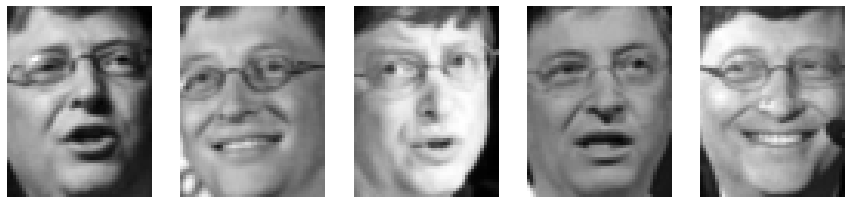

In [38]:
# show random images from both persons
import random

def show_pics(flist, k):
    plt.figure(figsize=(15, 40))
    for i, idx in enumerate(random.sample(list(flist), k)):
        plt.subplot(1, k, i+1)
        plt.imshow(faces.images[idx,:,:], cmap=plt.cm.gray)
        plt.axis('off')
        
show_pics(watts_idx, 5)
show_pics(gates_idx, 5)

In [41]:
# get coordinates for both using 2 eigenfaces
eigen_modes = [4, 10]
def get_coord(flist):
    res = np.zeros((len(flist), 2))
    for i, idx in enumerate(list(flist)):
        x = faces.images[idx,:,:].reshape(1 , -1) - mean_face
        alpha = (x @ Vt.T).reshape(-1)
        res[i,:] = alpha[eigen_modes]
    return res
naomi = get_coord(watts_idx)
bill = get_coord(gates_idx)

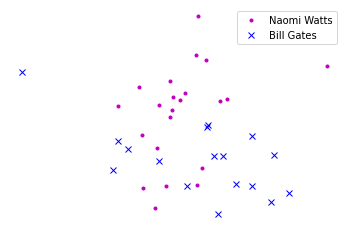

In [42]:
# plot them in 2D
plt.plot(naomi[:,0], naomi[:,1], '.', color='m', label='Naomi Watts')
plt.plot(bill[:,0], bill[:,1], 'x', color='b', label='Bill Gates')
plt.axis('off')
plt.legend()